<a href="https://colab.research.google.com/github/cinthia005/Lab-PDI/blob/main/Pr%C3%A1ctica8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRACTICA 8 - LABORATORIO DE PDI**
**EQUIPO 6:**

Cinthia Janeth Pecina Hernández	2062979	IB	509

Sofía Viridiana Estrada Rosales	2132066	IB	309

--- PROCESANDO PARTE I: ESPACIAL (RADIOGRAFIA.jpg) ---


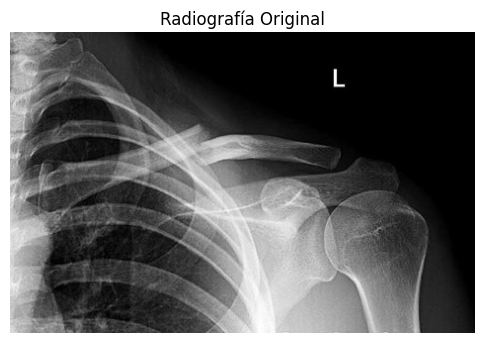

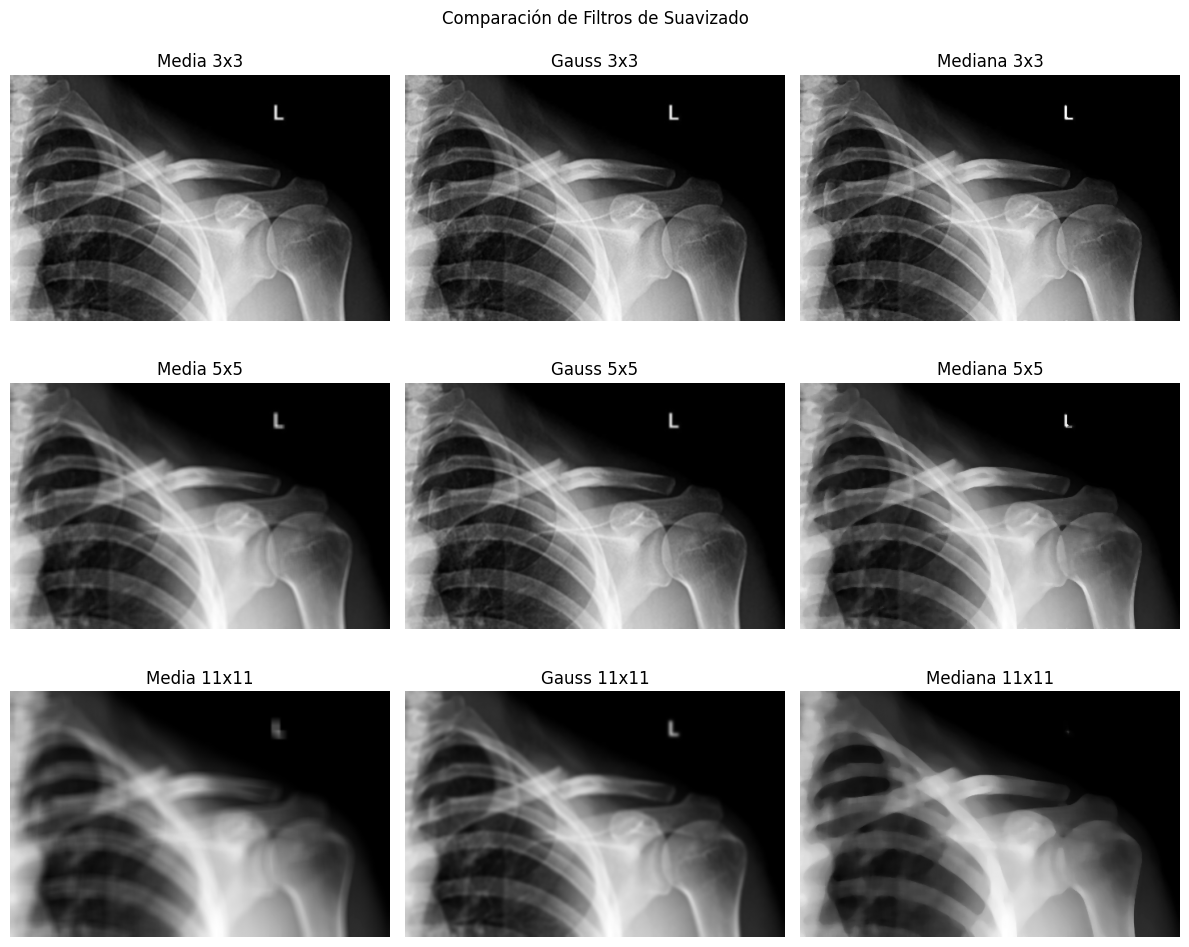

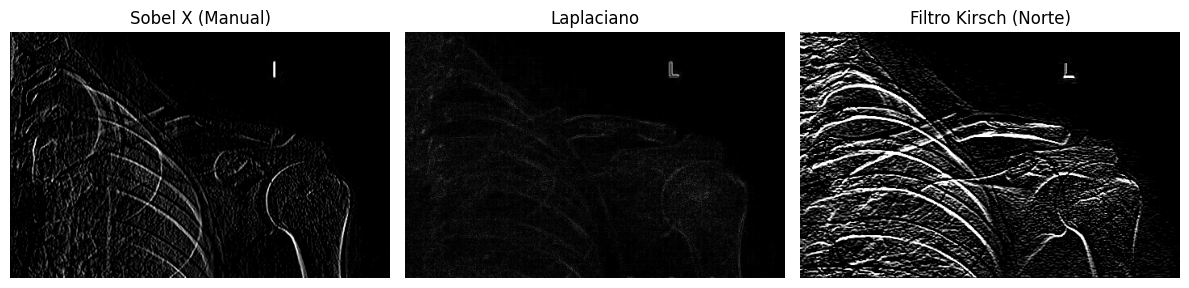

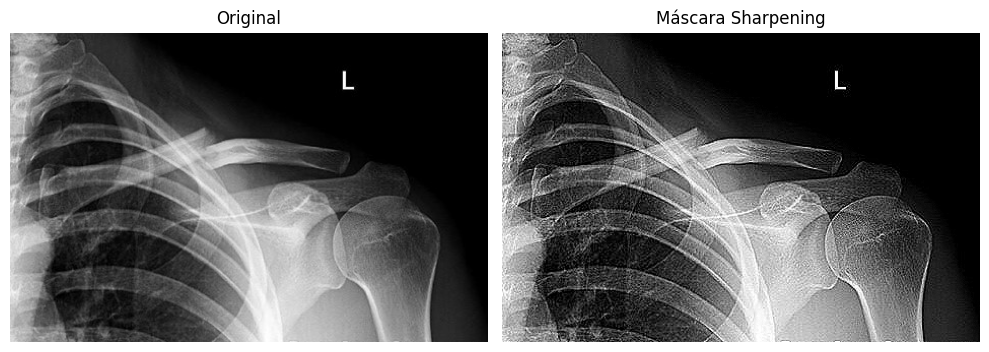


--- PROCESANDO PARTE II: FRECUENCIA ---
Procesando colonoscopia.jpg...


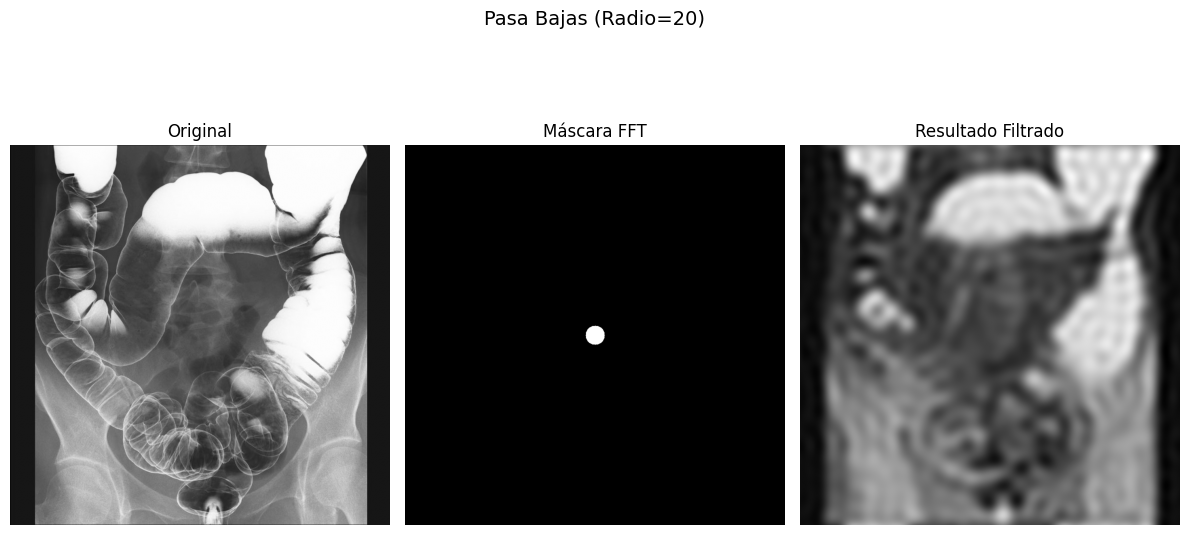

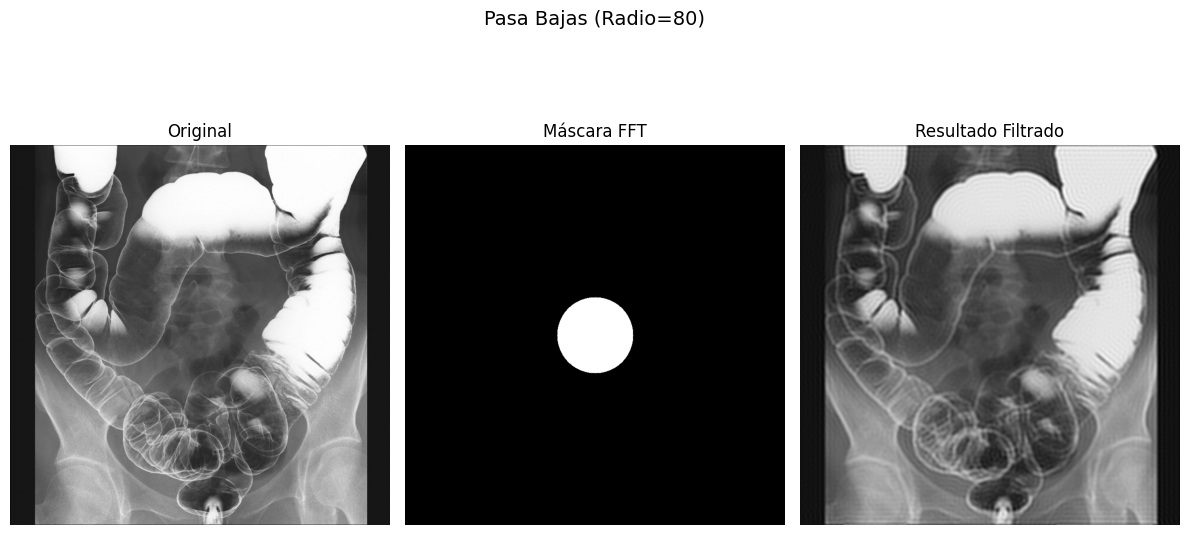

Procesando endoscopia.jpg...


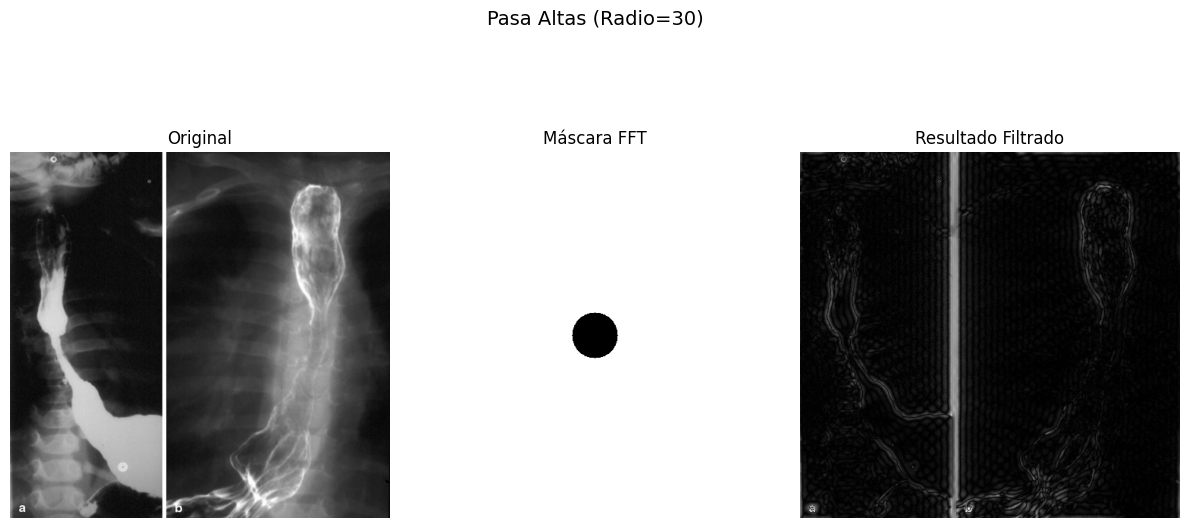

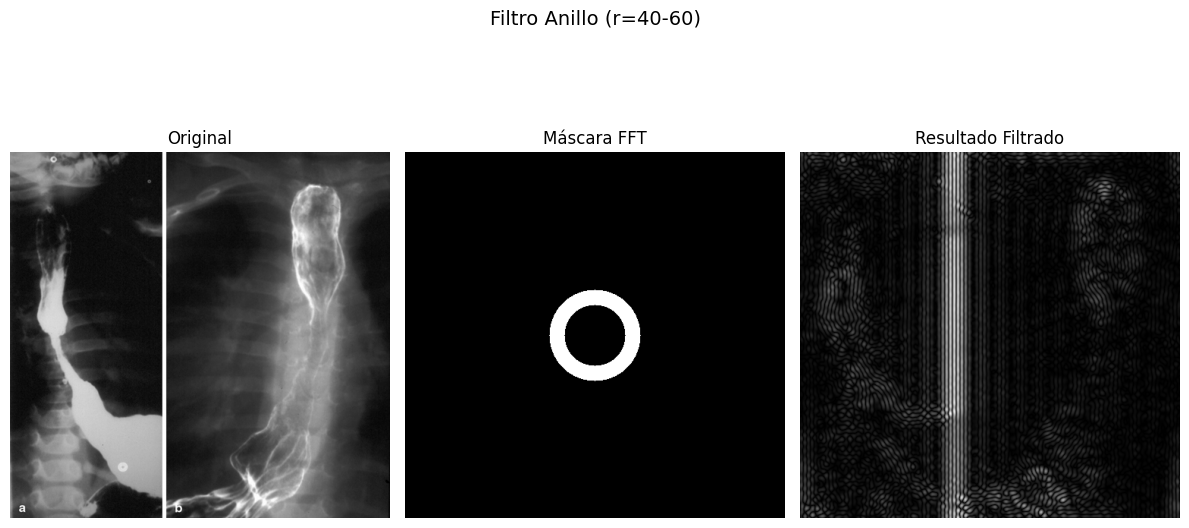

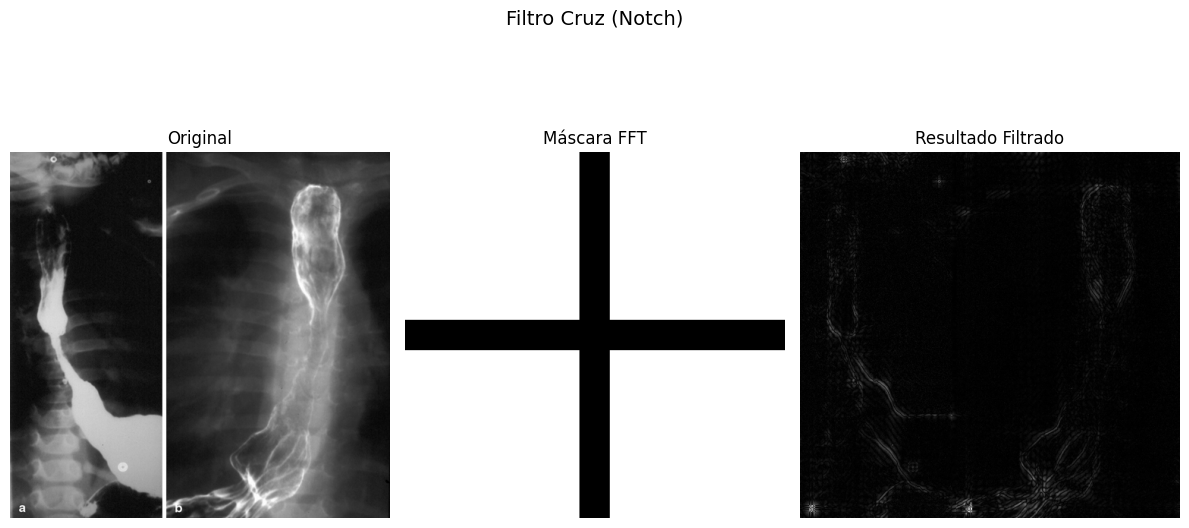

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURACIÓN DE NOMBRES DE ARCHIVO
# ==========================================
IMG_RADIO = 'RADIOGRAFIA.jpg'      # Para Parte 1 (Gris)
IMG_MED1 = 'colonoscopia.jpg'      # Para Parte 2 (Pasa Bajas)
IMG_MED2 = 'endoscopia.jpg'        # Para Parte 2 (Pasa Altas)

def mostrar_imagen(img, titulo="Imagen", cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.title(titulo)
    plt.axis('off')

# ==========================================
# PARTE I: FILTROS ESPACIALES
# ==========================================
print(f"--- PROCESANDO PARTE I: ESPACIAL ({IMG_RADIO}) ---")

# 1. Cargar imagen
img = cv2.imread(IMG_RADIO, 0) # Cargar en gris

if img is None:
    print(f"¡ERROR! No se encontró {IMG_RADIO}. Verifica el nombre.")
else:
    plt.figure(figsize=(6,6))
    mostrar_imagen(img, "Radiografía Original")
    plt.show()

    # 2. Filtros de Suavizado (Diferentes Kernels)
    kernels = [3, 5, 11]
    plt.figure(figsize=(12, 10)) # Hacemos la figura grande
    idx = 1
    for k in kernels:
        # Media
        media = cv2.blur(img, (k, k))
        plt.subplot(3, 3, idx), mostrar_imagen(media, f'Media {k}x{k}')
        idx += 1
        # Gaussiano
        gauss = cv2.GaussianBlur(img, (k, k), 0)
        plt.subplot(3, 3, idx), mostrar_imagen(gauss, f'Gauss {k}x{k}')
        idx += 1
        # Mediana
        mediana = cv2.medianBlur(img, k)
        plt.subplot(3, 3, idx), mostrar_imagen(mediana, f'Mediana {k}x{k}')
        idx += 1
    plt.suptitle("Comparación de Filtros de Suavizado")
    plt.tight_layout()
    plt.show()

    # 3. Detección de Bordes (Manual vs Automático)
    # Sobel X manual
    mask_sobel_x = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])
    res_sobel_x = cv2.filter2D(img, -1, mask_sobel_x)

    # Kirsch (Dirección Norte) - Manual
    mask_kirsch_n = np.array([[ 5,  5,  5],
                            [-3,  0, -3],
                            [-3, -3, -3]])
    res_kirsch = cv2.filter2D(img, -1, mask_kirsch_n)

    # Laplaciano (Automático)
    res_laplacian = cv2.Laplacian(img, cv2.CV_64F)

    plt.figure(figsize=(12, 5))
    plt.subplot(131), mostrar_imagen(res_sobel_x, "Sobel X (Manual)")
    plt.subplot(132), mostrar_imagen(np.abs(res_laplacian), "Laplaciano")
    plt.subplot(133), mostrar_imagen(res_kirsch, "Filtro Kirsch (Norte)")
    plt.tight_layout()
    plt.show()

    # 4. Máscara Personalizada (Realce/Sharpening)
    mask_custom = np.array([[ 0, -1,  0],
                            [-1,  5, -1],
                            [ 0, -1,  0]])
    res_custom = cv2.filter2D(img, -1, mask_custom)

    plt.figure(figsize=(10, 5))
    plt.subplot(121), mostrar_imagen(img, "Original")
    plt.subplot(122), mostrar_imagen(res_custom, "Máscara Sharpening")
    plt.tight_layout()
    plt.show()


# ==========================================
# PARTE II: DOMINIO DE LA FRECUENCIA
# ==========================================
print("\n--- PROCESANDO PARTE II: FRECUENCIA ---")

def aplicar_filtro_frecuencia(imagen_path, tipo_filtro, parametro):
    img_med = cv2.imread(imagen_path, 0)
    if img_med is None:
        print(f"Error cargando {imagen_path}")
        return

    # 1. FFT
    f = np.fft.fft2(img_med)
    fshift = np.fft.fftshift(f)
    rows, cols = img_med.shape
    crow, ccol = rows//2, cols//2

    # 2. Crear Máscara
    mask = np.zeros((rows, cols), np.uint8)
    nombre = ""

    if tipo_filtro == 'pasa_bajas':
        cv2.circle(mask, (ccol, crow), parametro, 1, -1)
        nombre = f"Pasa Bajas (Radio={parametro})"

    elif tipo_filtro == 'pasa_altas_circulo':
        mask = np.ones((rows, cols), np.uint8)
        cv2.circle(mask, (ccol, crow), parametro, 0, -1)
        nombre = f"Pasa Altas (Radio={parametro})"

    elif tipo_filtro == 'pasa_altas_anillo':
        mask = np.zeros((rows, cols), np.uint8)
        cv2.circle(mask, (ccol, crow), parametro + 20, 1, -1)
        cv2.circle(mask, (ccol, crow), parametro, 0, -1)
        nombre = f"Filtro Anillo (r={parametro}-{parametro+20})"

    elif tipo_filtro == 'pasa_altas_cruz':
        mask = np.ones((rows, cols), np.uint8)
        # Grosor de la cruz ajustado
        mask[crow-20:crow+20, :] = 0
        mask[:, ccol-20:ccol+20] = 0
        nombre = "Filtro Cruz (Notch)"

    # 3. Aplicar máscara
    fshift_filtered = fshift * mask

    # 4. Inversa
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # VISUALIZACIÓN AJUSTADA (Para imágenes verticales)
    plt.figure(figsize=(12, 6)) # Más alto para que quepa bien

    plt.subplot(131)
    mostrar_imagen(img_med, "Original")

    plt.subplot(132)
    mostrar_imagen(mask * 255, "Máscara FFT")

    plt.subplot(133)
    mostrar_imagen(img_back, "Resultado Filtrado")

    plt.suptitle(nombre, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85) # Espacio para el título
    plt.show()

# EJECUCIÓN PARTE II
# Imagen 1 (Colonoscopia): Pasa Bajas
print(f"Procesando {IMG_MED1}...")
aplicar_filtro_frecuencia(IMG_MED1, 'pasa_bajas', 20)
aplicar_filtro_frecuencia(IMG_MED1, 'pasa_bajas', 80)

# Imagen 2 (Endoscopia): Pasa Altas y Formas
print(f"Procesando {IMG_MED2}...")
aplicar_filtro_frecuencia(IMG_MED2, 'pasa_altas_circulo', 30) # Círculo
aplicar_filtro_frecuencia(IMG_MED2, 'pasa_altas_anillo', 40)   # Anillo
aplicar_filtro_frecuencia(IMG_MED2, 'pasa_altas_cruz', 0)      # Cruz